In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
import os
import scanpy as sc
from statsmodels.stats.multitest import multipletests
import sys
sys.path.append("../src")
from evaluation_metrics import *
from utils_evaluation import *

In [3]:
from statsmodels.stats.multitest import multipletests

In [4]:
bm_results_dfs, mon_df, melted_mon = get_mon_df()
ssnr_results_dfs, ssnr_df, melted_ssnr = get_ssnr_df(bm_results_dfs)
var_results_dfs, var_df, melted_var = get_sv_df()

/data/bionets/je30bery/rosenbaum_test/notebooks/../src/utils_evaluation.py:170: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  xm_results_dfs_var[dataset].replace({"split_10": 10, "split_30": 30, "split_50": 50}, inplace=True)
/data/bionets/je30bery/rosenbaum_test/notebooks/../src/utils_evaluation.py:170: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  xm_results_dfs_var[dataset].replace({"split_10": 10, "split_30": 30, "split_50": 50}, inplace=True)
/data/bionets/je30bery/rosenbaum_test/notebooks/../src/utils_evaluation.py:170: Futu

In [6]:
FPR = np.sum(ssnr_results_dfs["scXMatch"] >= 0.95) / len(ssnr_results_dfs)
FPR

0.02

In [21]:
ssnr_results_dfs

augur  wilcoxon  deseq2_100  edgeR_100  \
             test_group split                                              
mcfarland    24         10     0.499853     0.041      0.0850     0.1090   
             6          10     0.528628     0.054      0.0260     0.0670   
             24         30     0.497279     0.038      0.0335     0.0985   
             6          30     0.499932     0.025      0.0175     0.0545   
             24         50     0.442188     0.040      0.0360     0.1175   
...                                 ...       ...         ...        ...   
sciplex_MCF7 10000.0    30     0.485011     0.051      0.2545     0.1445   
             10.0       50     0.501202     0.038      0.0370     0.0680   
             100.0      50     0.509036     0.055      0.0430     0.0700   
             1000.0     50     0.505499     0.066      0.0480     0.0800   
             10000.0    50     0.491361     0.046      0.0580     0.0820   

                               deseq2_200  edgeR_200  deseq2_500  edgeR_500  \
             test_group split                                                 
mcfarland    24         10         0.0585     0.0770        92.0      114.0   
             6          10         0.0285     0.0575         NaN        NaN   
             24         30         0.0310     0.0730        41.0       96.0   
             6          30         0.0095     0.0285         NaN        NaN   
             24         50         0.0350     0.0770        52.0       94.0   
...                                   ...        ...         ...        ...   
sciplex_MCF7 10000.0    30         0.1560     0.1010       176.0      165.0   
             10.0       50         0.0395     0.0645        83.0      112.0   
             100.0      50         0.0410     0.0655        91.0      112.0   
             1000.0     50         0.0500     0.0715       101.0      126.0   
             10000.0    50         0.0610     0.0795       117.0      131.0   

                               scXMatch  
             test_group split            
mcfarland    24         10     0.736002  
             6          10     0.837309  
             24         30     0.444140  
             6          30     0.470318  
             24         50     0.099273  
...                                 ...  
sciplex_MCF7 10000.0    30     0.276215  
             10.0       50     0.413875  
             100.0      50     0.258307  
             1000.0     50     0.704115  
             10000.0    50     0.045063  

[150 rows x 9 columns]

In [7]:
FPR_adj = 0
total_len = 0
for dataset in melted_ssnr["dataset"].unique():
    if "bhattacherjee" in dataset:
        continue
    for group in ssnr_results_dfs.loc[dataset].reset_index()["test_group"].unique():
        p_vals = 1 - ssnr_results_dfs.loc[(dataset, group)]["scXMatch"].values
        adj_pvals = multipletests(p_vals, method="fdr_bh")[1]
        FPR_adj += np.sum(adj_pvals < 0.05)
        total_len += len(adj_pvals)
print(FPR_adj / total_len)

0.013333333333333334


/tmp/ipykernel_2294415/1634572856.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  p_vals = 1 - ssnr_results_dfs.loc[(dataset, group)]["scXMatch"].values
/tmp/ipykernel_2294415/1634572856.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  p_vals = 1 - ssnr_results_dfs.loc[(dataset, group)]["scXMatch"].values
/tmp/ipykernel_2294415/1634572856.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  p_vals = 1 - ssnr_results_dfs.loc[(dataset, group)]["scXMatch"].values
/tmp/ipykernel_2294415/1634572856.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  p_vals = 1 - ssnr_results_dfs.loc[(dataset, group)]["scXMatch"].values
/tmp/ipykernel_2294415/1634572856.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  p_vals = 1 - ssnr_results_dfs.loc[(dataset, group)]["scXMatch"].values
/tmp/ipykernel_2294415/1634572856.py:7: PerformanceWarning: indexing past l

In [ ]:
#pd.concat(bm_results_dfs).sort_index().to_excel("monotonicity.xlsx")
#ssnr_results_dfs.sort_index().to_excel("ssnr.xlsx")
#var_results_dfs.sort_index().to_excel("sv.xlsx")

In [8]:
f = np.vectorize(round_sig)

In [9]:
mon_df.apply(f)

,mcfarland,norman,schiebinger,sciplex_A549,sciplex_K562,sciplex_MCF7
augur,0,1.0,0.73,0.67,0.67,1.0
wilcoxon,0,1.0,0.93,0.83,1.00,1.0
deseq2_100,1,1.0,0.93,1.00,1.00,1.0
edgeR_100,1,1.0,0.94,1.00,1.00,1.0
scXMatch,1,1.0,1.00,1.00,0.67,1.0


In [10]:
ssnr_df.set_index("metric").apply(f)

,mcfarland,norman,schiebinger,sciplex_A549,sciplex_K562,sciplex_MCF7
metric,,,,,,
augur,1.0,1.0,1.0,0.75,0.67,0.33
wilcoxon,1.0,1.0,1.0,1.00,1.00,1.00
deseq2_100,1.0,1.0,1.0,0.50,0.33,0.67
edgeR_100,1.0,1.0,1.0,0.42,0.25,0.75
scXMatch,1.0,1.0,1.0,0.83,0.67,0.83


In [11]:
var_df.apply(f)

,mcfarland,norman,schiebinger,sciplex_A549,sciplex_K562,sciplex_MCF7
augur,0.000660,3.500000e-04,0.000082,0.00017,0.00021,0.00017
wilcoxon,0.005100,3.400000e-03,0.003100,0.00170,0.00071,0.00290
deseq2_100,0.003300,8.800000e-03,0.004700,0.00120,0.00074,0.00350
edgeR_100,0.004700,1.200000e-02,0.004400,0.00440,0.00500,0.00290
scXMatch,0.000082,2.000000e-07,0.000000,0.06500,0.06600,0.04500


In [12]:
pareto_counts, pareto_sets = compute_pareto_optimal_datasets(mon_df.apply(f), ssnr_df.set_index("metric").apply(f), var_df.apply(f))
samples = set()
for sample_list in pareto_sets.values():
    samples.update(sample_list)
heatmap_data = {method: [sample in sample_list for sample in samples] 
                for method, sample_list in pareto_sets.items()}
df = pd.DataFrame(heatmap_data, index=list(samples)).T

In [16]:
df = df.sort_index(axis=1)
df.rename({"deseq2_100": "#DEGs $DESeq2_{100}$", 
               "edgeR_100": "#DEGs $edgeR_{100}$",
              "augur": "$Augur$",
                "wilcoxon": "#DEGs $Wilcoxon$",
               "scXMatch": "$\mathbf{scXMatch}$",
               }, inplace=True, axis=0)
dummy_heatmap = np.ones([6, 5])
dummy_heatmap[:, 1] = 2
dummy_heatmap[:, 2] = 3
dummy_heatmap[:, 3] = 4
dummy_heatmap[:, 4] = 5
dummy_heatmap = pd.DataFrame(dummy_heatmap, columns=df.index, index=df.columns)
mask = df.T <= 0

In [17]:
melted_mon = melted_mon.sort_values("dataset")
melted_ssnr = melted_ssnr.sort_values("dataset")
melted_var = melted_var.sort_values("dataset")

In [18]:
palette = sns.color_palette("viridis", 4) + sns.color_palette("magma", 1)
palette_dict = {           
    '$Augur$': palette[0],
    '#DEGs $DESeq2_{100}$': palette[1],
    '#DEGs $Wilcoxon$': palette[2],
    '#DEGs $edgeR_{100}$': palette[3],
    '$\\mathbf{scXMatch}$': palette[4]}

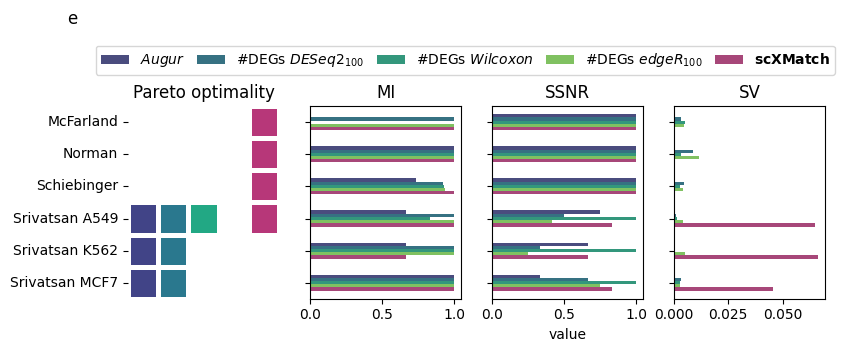

In [20]:
f, axs = plt.subplots(1, 4, figsize=(9, 2.5))


sns.heatmap(dummy_heatmap, mask=mask, linewidths=2.5, linecolor='white', ax=axs[0], cbar=False, cmap=palette)
axs[0].set_title("Pareto optimality")
#axs[0].set_yticklabels([])
axs[0].set_xticklabels([])
axs[0].set_xticks([])

sns.barplot(melted_mon, y="dataset", hue="metric", x="value", orient="h", palette=palette_dict, ax=axs[1], legend=True, width=0.5, hue_order=palette_dict.keys())
axs[1].set_title("MI")
axs[1].set_ylabel("")
axs[1].set_xlabel("")
axs[1].set_yticklabels([])

sns.barplot(melted_ssnr, y="dataset", hue="metric", x="value", orient="h", palette=palette_dict, ax=axs[2], legend=False, width=0.5, hue_order=palette_dict.keys())
axs[2].set_title("SSNR")
axs[2].set_ylabel("")
axs[2].set_yticklabels([])

sns.barplot(melted_var, y="dataset", hue="metric", x="value", orient="h", palette=palette_dict, ax=axs[3], legend=False, width=0.5, hue_order=palette_dict.keys())
axs[3].set_title("SV")
axs[3].set_ylabel("")
axs[3].set_xlabel("")
axs[3].set_yticklabels([])

handles, labels = axs[1].get_legend_handles_labels()
f.legend(handles, labels, loc='upper center', ncol=len(palette), bbox_to_anchor=(0.5, 1.15), columnspacing=0.9)
axs[1].legend_.remove()

axs[0].text(
    -0.4, 1.5,  # Position (normalized figure coordinates)
    "e",   # Corresponding letter
    transform=axs[0].transAxes,  # Relative to subplot
    fontsize=12, va='top', ha='left'
)

axs[0].set_yticklabels(["McFarland", "Norman", "Schiebinger", "Srivatsan A549", "Srivatsan K562", "Srivatsan MCF7"])
plt.savefig("../plots/fig3/fig3e.pdf", bbox_inches="tight")